In [145]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [146]:
import matplotlib.pyplot as plt
import numpy as np
import scipy
import skimage

In [147]:
def kernel_interpolate(x_input, y_input, x_interp, kernel):
    y_interp = np.zeros_like(x_interp)
    kernel_width = np.median(np.diff(x_input))
    for i, x in enumerate(x_interp):
        weights = kernel(np.divide((x - x_input), kernel_width))
        y_interp[i] = np.divide(np.sum(weights * y_input), np.sum(weights))
    return y_interp

def linear(t):
    return np.where((t >= - 1) & (t < 1), 1 - abs(t), 0)

In [148]:
def rgb_division_for_2D_interpolation(data, point_multiplier, interpolating_function_2D, interpolating_function, kernel):
    data_r, data_g, data_b = data[:, :, 0], data[:, :, 1], data[:, :, 2]

    cols, rows, rgb = data.shape
    result = np.zeros([cols * point_multiplier, rows * point_multiplier, rgb])

    result_r = interpolating_function_2D(data_r, point_multiplier, interpolating_function, kernel)
    result_g = interpolating_function_2D(data_g, point_multiplier, interpolating_function, kernel)
    result_b = interpolating_function_2D(data_b, point_multiplier, interpolating_function, kernel)

    for i in range(cols * point_multiplier):
       for j in range(rows * point_multiplier):
        result[i][j][0] = result_r[i][j]
        result[i][j][1] = result_g[i][j]
        result[i][j][2] = result_b[i][j]

    return result.astype(int)

def interpolate_2D(data, point_multiplier, interpolating_function, kernel):
    rows, cols = data.shape
    rows_interpolated = np.zeros((rows, cols * point_multiplier))

    for i in range(rows):
        rows_interpolated[i, :] = interpolating_function(np.arange(cols), data[i, :], np.linspace(0, cols - 1, cols * point_multiplier), kernel)

    result = np.zeros((rows * point_multiplier, cols * point_multiplier))

    for j in range(cols * point_multiplier):
        result[:, j] = interpolating_function(np.arange(rows), rows_interpolated[:, j], np.linspace(0, rows - 1, rows * point_multiplier), kernel)

    return result

In [149]:
def convolution(data, kernel, kernel_size, step, padding = 0, matrix = 0):
    result = []
    for i in range(0, len(data) - kernel_size, step):
        temp = []
        for j in range(0, len(data[0]) - kernel_size, step):
            if (i < (len(data)) - 1 and j < len(data[0]) - 1):
                temp.append(kernel((data[i:i+kernel_size,j:j+kernel_size]), kernel_size, matrix))
        result.append(temp)
    return np.array(result)

def graysacling(data):
    result = []
    for i in range(0, len(data)):
      temp = []
      for j in range(0, len(data[0])):
        temp.append(0.299 * data[i][j][0] + 0.587 * data[i][j][1] + 0.114 * data[i][j][2])
      result.append(temp)
    return np.array(result)

In [150]:
def edge_recognition_with_given_kernel(data, matrix_size, matrix):
  sum = 0
  for i in range(matrix_size):
    for j in range(matrix_size):
      sum += data[i][j] * matrix[i][j]
  return np.divide(sum, np.power(matrix_size, 2))


def convolution_for_demosaicing(data, kernel, kernel_size, matrix_r, matrix_g, matrix_b, step = 2):
    result = []
    for i in range(0, len(data) - kernel_size, step):
        temp = []
        for j in range(0, len(data[0]) - kernel_size, step):
            if (i < (len(data)) - 1 and j < len(data[0]) - 1):
                temp.append(kernel((data[i:i+kernel_size,j:j+kernel_size]), kernel_size, matrix_r, matrix_g, matrix_b))
        result.append(temp)
    return np.array(result)


def demosaicing_with_given_kernel(data, matrix_size, matrix_red, matrix_green, matrix_blue):
  sum = [0, 0, 0]
  for i in range(matrix_size):
    for j in range(matrix_size):
      for k in range(3):
          sum[0] += data[i][j][k] * matrix_red[i][j]
          sum[1] += data[i][j][k] * matrix_green[i][j]
          sum[2] += data[i][j][k] * matrix_blue[i][j]

  return np.array(sum)


def demosaicing_with_given_kernel(data, matrix_size, matrix_red, matrix_green, matrix_blue):
  sum = [0, 0, 0]
  for i in range(matrix_size):
    for j in range(matrix_size):
      for k in range(3):
          sum[0] += data[i][j][k] * matrix_red[i][j]
          sum[1] += data[i][j][k] * matrix_green[i][j]
          sum[2] += data[i][j][k] * matrix_blue[i][j]

  return np.array(sum)


Bayer_green = np.array([[1/2, 0], [0, 1/2]])
Bayer_blue = np.array([[0, 0], [1, 0]])
Bayer_red = np.array([[0, 1], [0, 0]])

Fuji_green = np.array([[1/20, 0, 0, 1/20, 0, 0], [0, 1/20, 1/20, 0, 1/20, 1/20], [0, 1/20, 1/20, 0, 1/20, 1/20], [1/20, 0, 0, 1/20, 0, 0], [0, 1/20, 1/20, 0, 1/20, 1/20], [0, 1/20, 1/20, 0, 1/20, 1/20]])
Fuji_red = np.array([[0, 0, 1/8, 0, 0, 1/8], [1/8, 0, 0, 0, 0, 0], [0, 0, 0, 1/8, 0, 0], [0, 0, 1/8, 0, 0, 1/8], [1/8, 0, 0, 0, 0, 0], [0, 0, 0, 1/8, 0, 0]])
Fuji_blue = np.array([[0, 1/8, 0, 0, 1/8, 0], [0, 0, 0, 1/8, 0, 0], [1/8, 0, 0, 0, 0, 0], [0, 1/8, 0, 0, 1/8, 0], [0, 0, 0, 1/8, 0, 0], [1/8, 0, 0, 0, 0, 0]])

In [151]:
circle_bayer = np.load("/content/drive/MyDrive/CFA_NPY/Bayer/circle.npy")
mond_bayer = np.load("/content/drive/MyDrive/CFA_NPY/Bayer/mond.npy")
milky_bayer = np.load("/content/drive/MyDrive/CFA_NPY/Bayer/milky-way.npy")
namib_bayer = np.load("/content/drive/MyDrive/CFA_NPY/Bayer/namib.npy")
pandas_bayer = np.load("/content/drive/MyDrive/CFA_NPY/Bayer/pandas.npy")

circle_fuji = np.load("/content/drive/MyDrive/CFA_NPY/Fuji/circle.npy")
mond_fuji = np.load("/content/drive/MyDrive/CFA_NPY/Fuji/mond.npy")
milky_fuji = np.load("/content/drive/MyDrive/CFA_NPY/Fuji/milky-way.npy")
namib_fuji = np.load("/content/drive/MyDrive/CFA_NPY/Fuji/namib.npy")
panda_fuji = np.load("/content/drive/MyDrive/CFA_NPY/Fuji/panda.npy")

raw_image = np.load("/content/drive/MyDrive/CFA_NPY/Fuji/fuji_xtrans_image.npy")

In [152]:
camera_grayscale = skimage.data.camera()

astronaut_color = skimage.data.astronaut()

astronaut_grayscale = graysacling(astronaut_color)

In [153]:
laplace = np.array([[0, -1, 0], [-1, 4, -1],[0, -1, 0]])
laplace_rotated = np.array([[-1, 0, -1], [0, 4, 0],[-1, 0, -1]])

sobel_feldman_y = np.array([[-1, -2, -1], [0, 0, 0],[1, 2, 1]])
sobel_feldman_x = np.transpose(sobel_feldman_y)

sobel_feldman_y_5 = np.array([[2, 2, 4, 2, 2], [1, 1, 2, 1, 1], [0, 0, 0, 0, 0], [-1, -1, -2, -1, -1], [-2, -2, -4, -2, -2]])
sobel_feldman_x_5 = np.transpose(sobel_feldman_y_5)

sharr_operator_x = np.array([[-3, 0, +3], [-10, 0, +10],[-3, 0, +3]])
sharr_operator_y =  np.transpose(sharr_operator_x)

prewitt_operator_0 = np.array([[-1, -1, -1], [0, 0, 0], [1, 1, 1]])
prewitt_operator_180 = np.transpose(prewitt_operator_0)
prewitt_operator_90 = np.array([[-1, 0, 1], [-1, 0, 1], [-1, 0, 1]])
prewitt_operator_270 = np.transpose(prewitt_operator_90)
prewitt_operator_45 = np.array([[-1,-1, 0], [-1, 0, 1], [0, 1, 1]])
prewitt_operator_225 = np.transpose(prewitt_operator_45)
prewitt_operator_135 = np.array([[0, 1, 1], [-1, 0, 1], [-1, -1, 0]])
prewitt_operator_315 = np.transpose(prewitt_operator_135)

prewitt_operator_y_5 = np.array([[9, 9, 9, 9, 9], [9, 5, 5, 5, 9], [-7, -3, 0, -3, -7], [-7, -3, -3, -3, -7], [-7, -7, -7, -7, -7]])
prewitt_operator_x_5 = np.transpose(prewitt_operator_y_5)

gaussian_blur = 1/16 * np.array([[1, 2, 1], [1, 4, 1],[1, 2, 1]])
sharperning = np.array([[0, -1, 0], [-1, 5, -1],[0, -1, 0]])

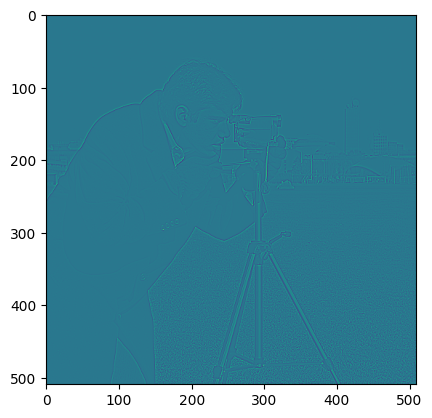

In [154]:
plt.imshow(convolution(camera_grayscale, edge_recognition_with_given_kernel, 3, 1, 1, laplace))
plt.show()

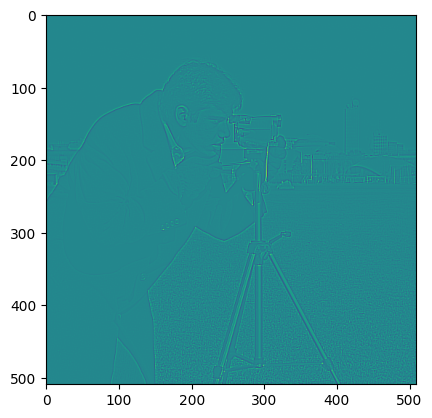

In [155]:
plt.imshow(convolution(camera_grayscale, edge_recognition_with_given_kernel, 3, 1, 1, laplace_rotated))
plt.show()

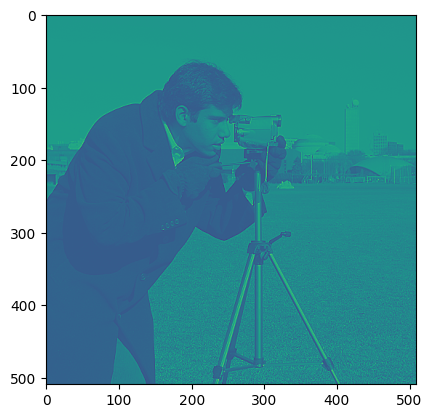

In [156]:
plt.imshow(convolution(camera_grayscale, edge_recognition_with_given_kernel, 3, 1, 1, sharperning))
plt.show()

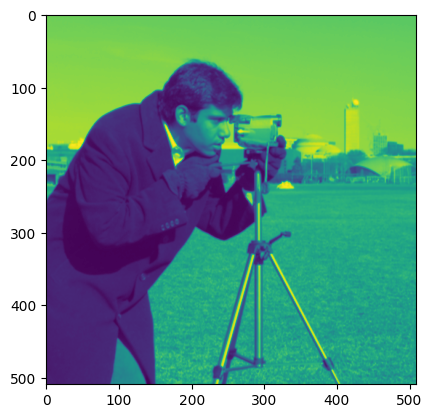

In [157]:
plt.imshow(convolution(camera_grayscale, edge_recognition_with_given_kernel, 3, 1, 1, gaussian_blur))
plt.show()

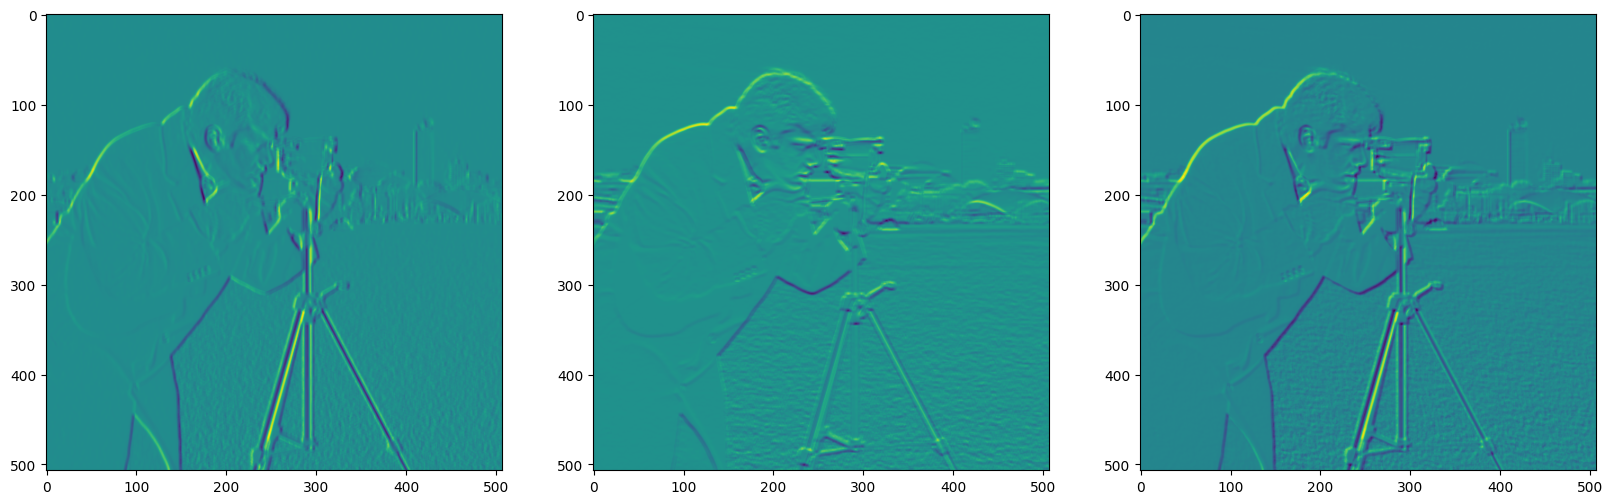

In [158]:
camera_grayscale_prewitt_operator_y_5 = convolution(camera_grayscale, edge_recognition_with_given_kernel, 5, 1, 1, prewitt_operator_y_5)
camera_grayscale_prewitt_operator_x_5 = convolution(camera_grayscale, edge_recognition_with_given_kernel, 5, 1, 1, prewitt_operator_x_5)
camera_grayscale_prewitt_operator_xy_5 = camera_grayscale_prewitt_operator_y_5 + camera_grayscale_prewitt_operator_x_5

fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (20, 10))
ax[0].imshow(camera_grayscale_prewitt_operator_x_5)
ax[1].imshow(camera_grayscale_prewitt_operator_y_5)
ax[2].imshow(camera_grayscale_prewitt_operator_xy_5)
plt.show()

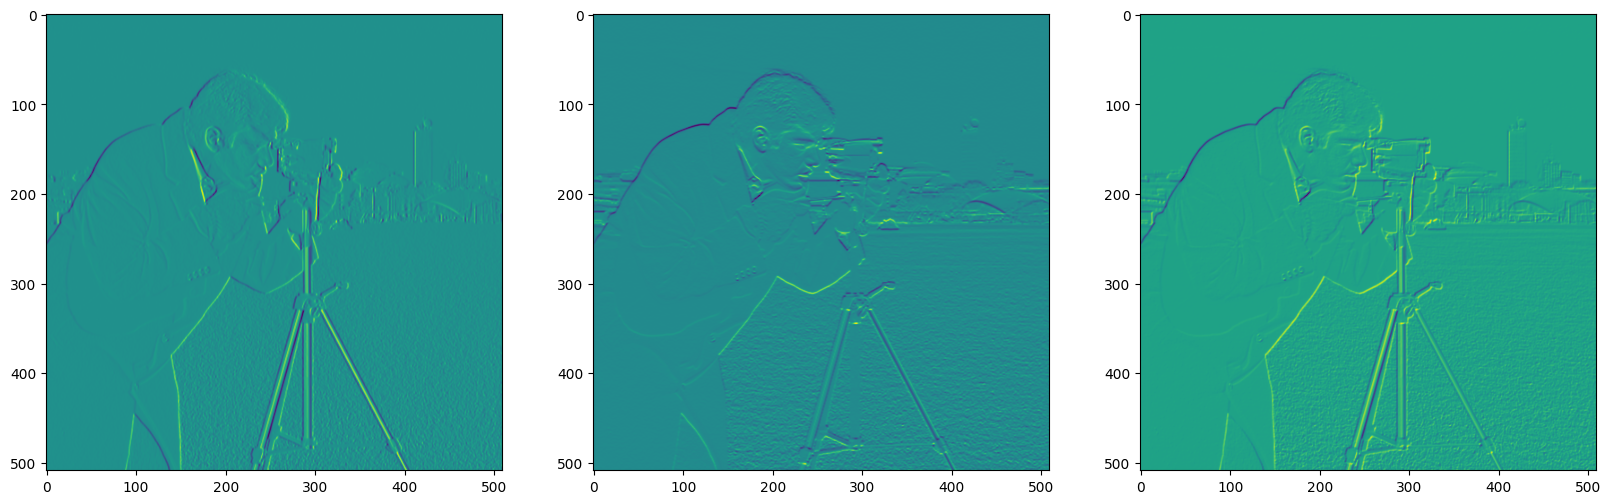

In [159]:
camera_grayscale_sobel_feldman_x = convolution(camera_grayscale, edge_recognition_with_given_kernel, 3, 1, 1, sobel_feldman_x)
camera_grayscale_sobel_feldman_y = convolution(camera_grayscale, edge_recognition_with_given_kernel, 3, 1, 1, sobel_feldman_y)
camera_grayscale_sobel_feldman_xy = camera_grayscale_sobel_feldman_x + camera_grayscale_sobel_feldman_y

fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (20, 10))
ax[0].imshow(camera_grayscale_sobel_feldman_x)
ax[1].imshow(camera_grayscale_sobel_feldman_y)
ax[2].imshow(camera_grayscale_sobel_feldman_xy)
plt.show()

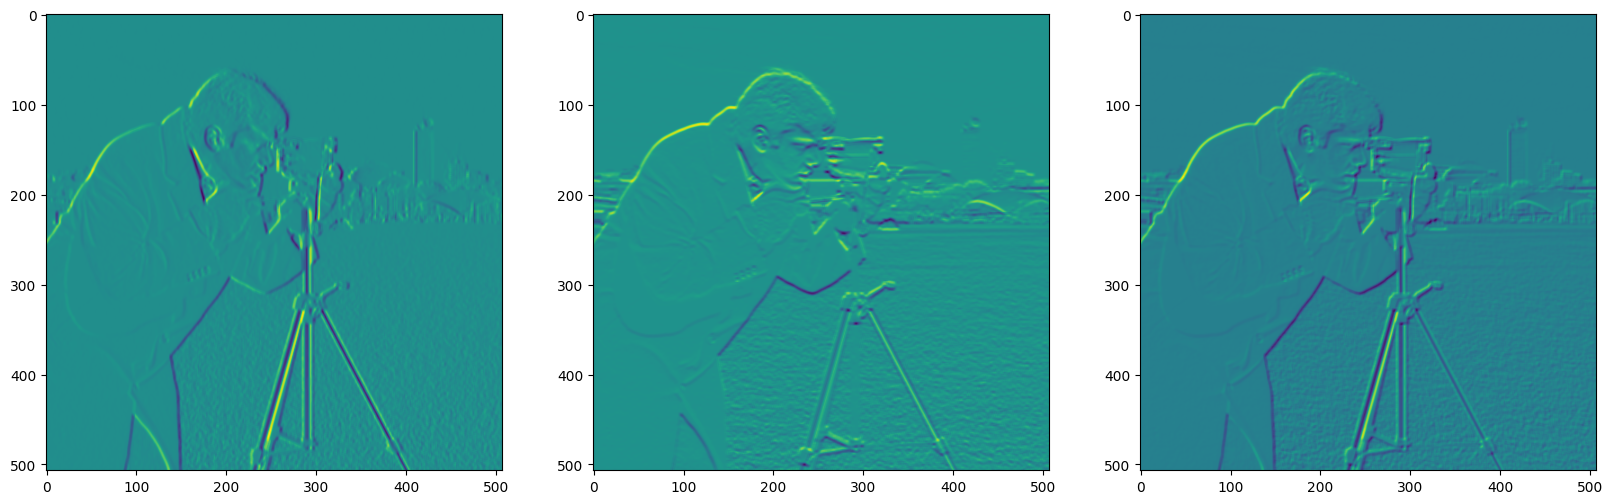

In [160]:
camera_grayscale_sobel_feldman_x_5 = convolution(camera_grayscale, edge_recognition_with_given_kernel, 5, 1, 1, sobel_feldman_x_5)
camera_grayscale_sobel_feldman_y_5 = convolution(camera_grayscale, edge_recognition_with_given_kernel, 5, 1, 1, sobel_feldman_y_5)
camera_grayscale_sobel_feldman_xy_5 = camera_grayscale_sobel_feldman_x_5 + camera_grayscale_sobel_feldman_y_5

fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (20, 10))

ax[0].imshow(camera_grayscale_sobel_feldman_x_5)
ax[1].imshow(camera_grayscale_sobel_feldman_y_5)
ax[2].imshow(camera_grayscale_sobel_feldman_xy_5)

plt.show()

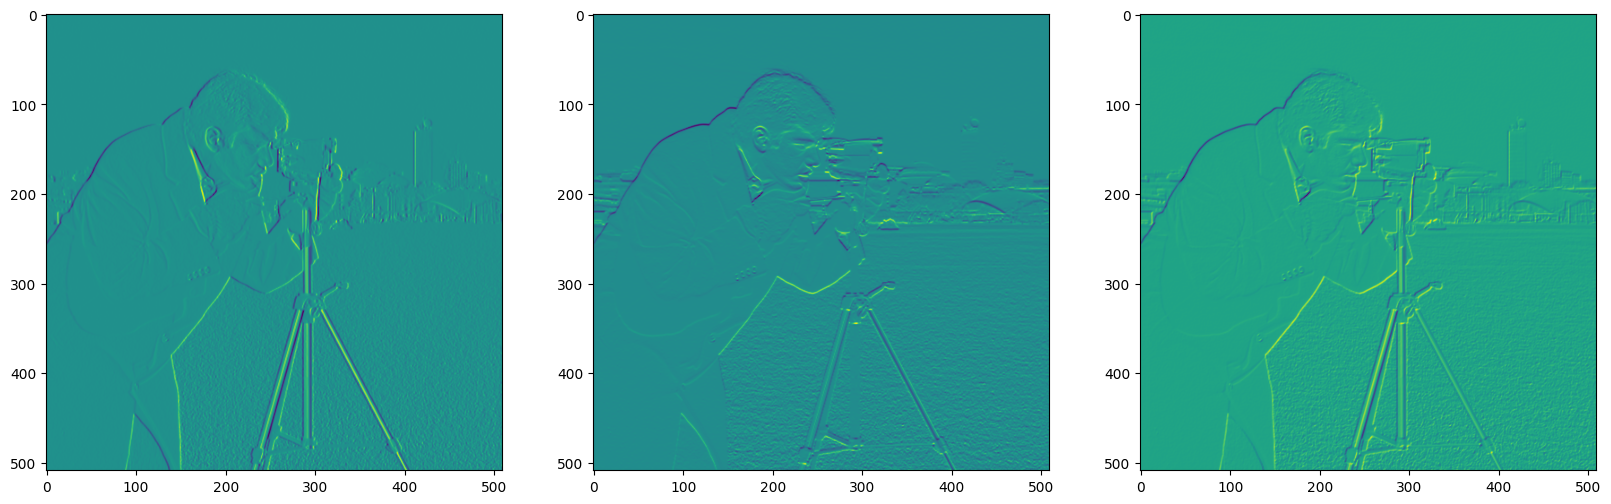

In [161]:
sharr_operator_x = np.array([[-3, 0, +3], [-10, 0, +10],[-3, 0, +3]])
sharr_operator_y =  np.transpose(sharr_operator_x)

camera_grayscale_sharr_operator_x = convolution(camera_grayscale, edge_recognition_with_given_kernel, 3, 1, 1, sharr_operator_x)
camera_grayscale_sharr_operator_y = convolution(camera_grayscale, edge_recognition_with_given_kernel, 3, 1, 1, sharr_operator_y)
camera_grayscale_sharr_operator_xy = camera_grayscale_sharr_operator_x + camera_grayscale_sharr_operator_y

fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (20, 10))

ax[0].imshow(camera_grayscale_sharr_operator_x)
ax[1].imshow(camera_grayscale_sharr_operator_y)
ax[2].imshow(camera_grayscale_sharr_operator_xy)

plt.show()

In [162]:
camera_grayscale_prewitt_operator_0 = convolution(camera_grayscale, edge_recognition_with_given_kernel, 3, 1, 1, prewitt_operator_0)

camera_grayscale_prewitt_operator_45 = convolution(camera_grayscale, edge_recognition_with_given_kernel, 3, 1, 1, prewitt_operator_45)

camera_grayscale_prewitt_operator_90 = convolution(camera_grayscale, edge_recognition_with_given_kernel, 3, 1, 1, prewitt_operator_90)

camera_grayscale_prewitt_operator_135 = convolution(camera_grayscale, edge_recognition_with_given_kernel, 3, 1, 1, prewitt_operator_135)

camera_grayscale_prewitt_operator_180 = convolution(camera_grayscale, edge_recognition_with_given_kernel, 3, 1, 1, prewitt_operator_180)

camera_grayscale_prewitt_operator_225 = convolution(camera_grayscale, edge_recognition_with_given_kernel, 3, 1, 1, prewitt_operator_225)

camera_grayscale_prewitt_operator_270 = convolution(camera_grayscale, edge_recognition_with_given_kernel, 3, 1, 1, prewitt_operator_270)

camera_grayscale_prewitt_operator_315 = convolution(camera_grayscale, edge_recognition_with_given_kernel, 3, 1, 1, prewitt_operator_315)

In [163]:
camera_grayscale_prewitt_operator_all = camera_grayscale_prewitt_operator_0 + camera_grayscale_prewitt_operator_45 + camera_grayscale_prewitt_operator_90 + camera_grayscale_prewitt_operator_135 + camera_grayscale_prewitt_operator_180 + camera_grayscale_prewitt_operator_225 + camera_grayscale_prewitt_operator_270 + camera_grayscale_prewitt_operator_315

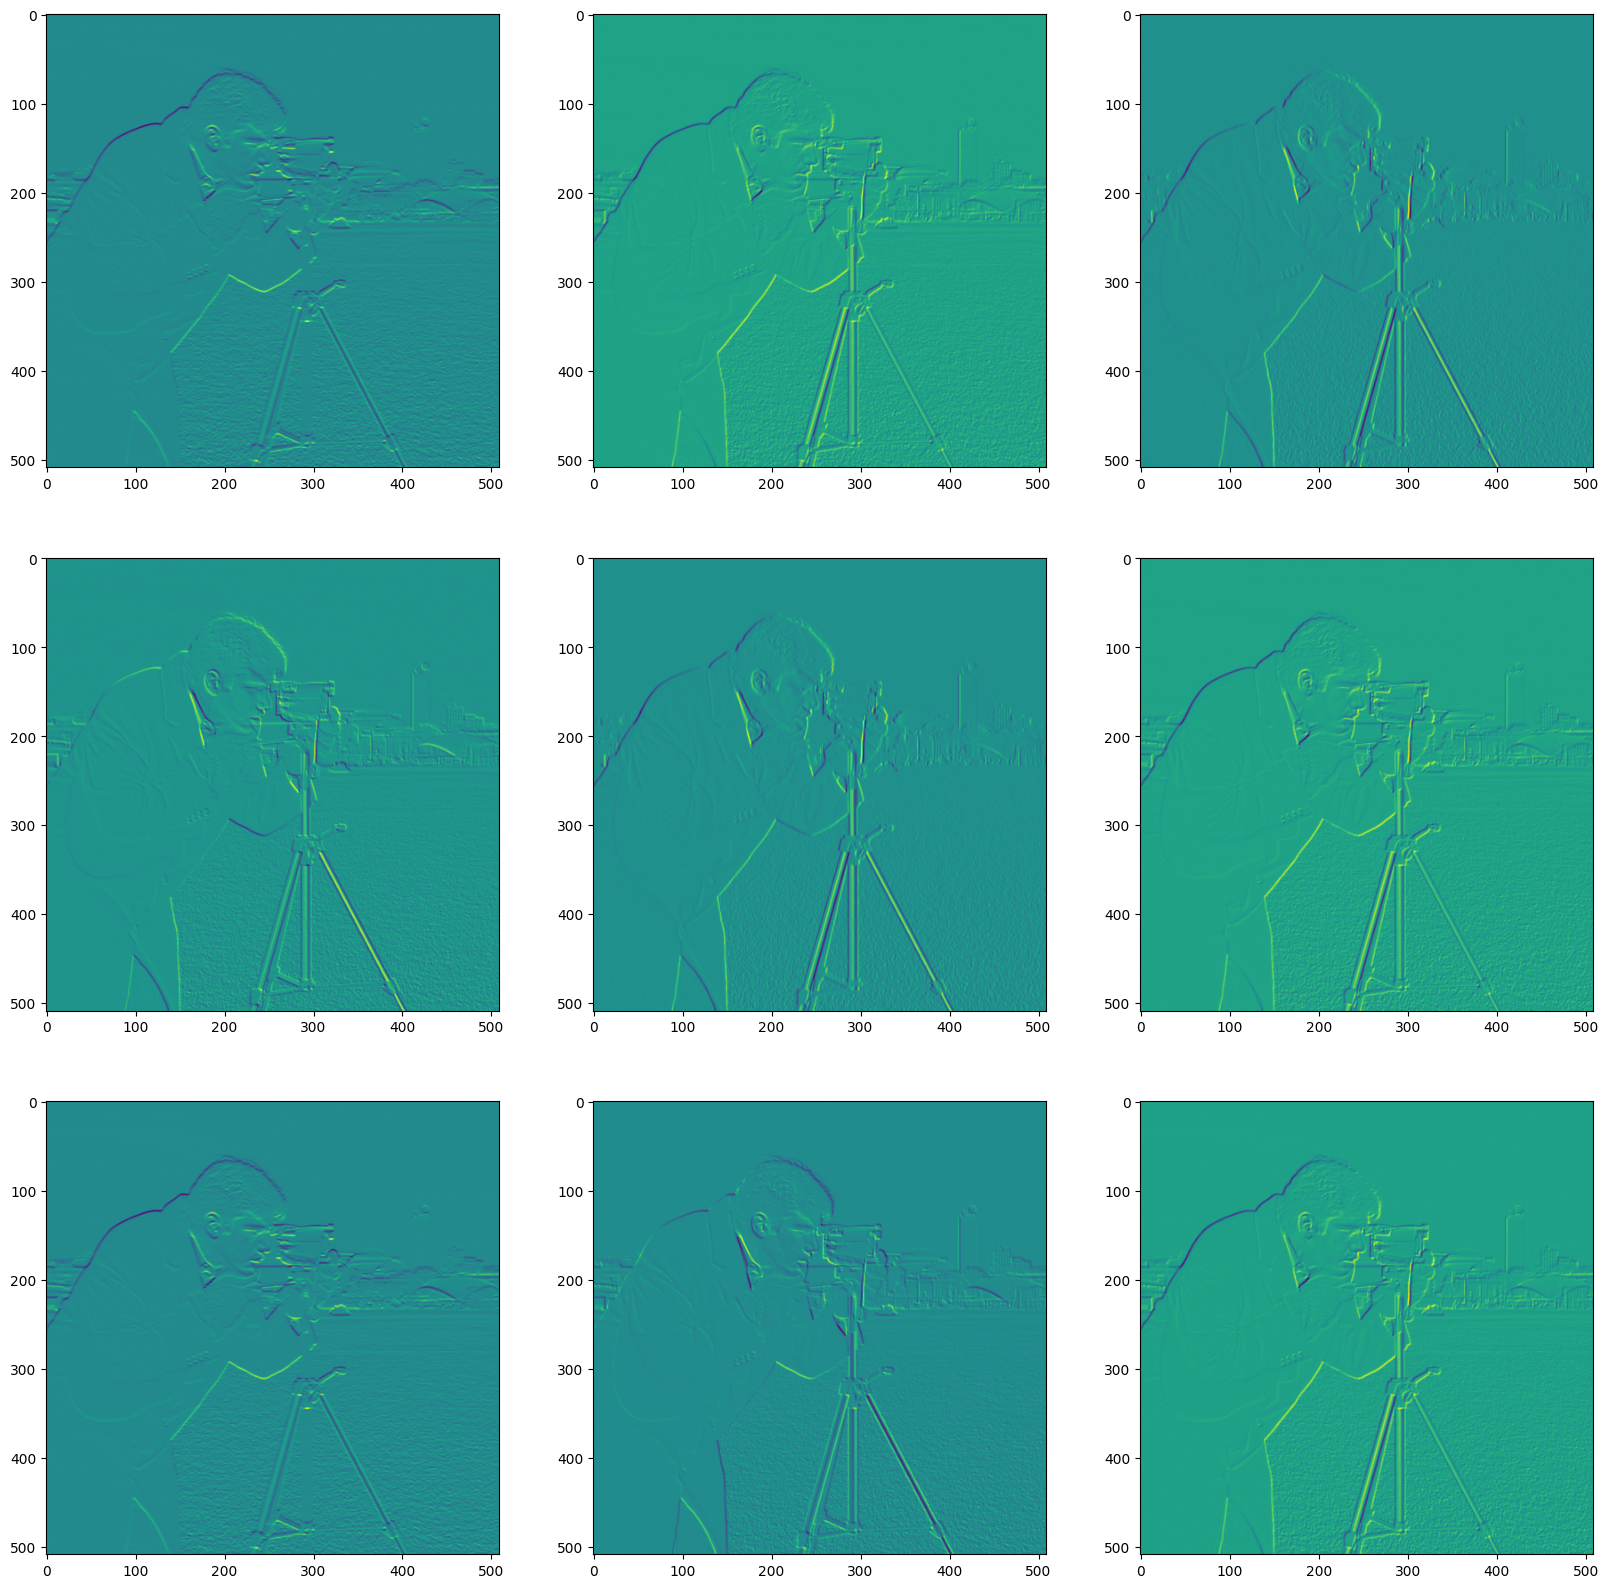

In [164]:
fig, ax = plt.subplots(nrows = 3, ncols = 3, figsize = (20, 20))
ax[0, 0].imshow(camera_grayscale_prewitt_operator_0)
ax[0, 1].imshow(camera_grayscale_prewitt_operator_45)
ax[0, 2].imshow(camera_grayscale_prewitt_operator_90)
ax[1, 0].imshow(camera_grayscale_prewitt_operator_135)
ax[1, 1].imshow(camera_grayscale_prewitt_operator_180)
ax[1, 2].imshow(camera_grayscale_prewitt_operator_225)
ax[2, 0].imshow(camera_grayscale_prewitt_operator_270)
ax[2, 1].imshow(camera_grayscale_prewitt_operator_315)
ax[2, 2].imshow(camera_grayscale_prewitt_operator_all)
plt.show()

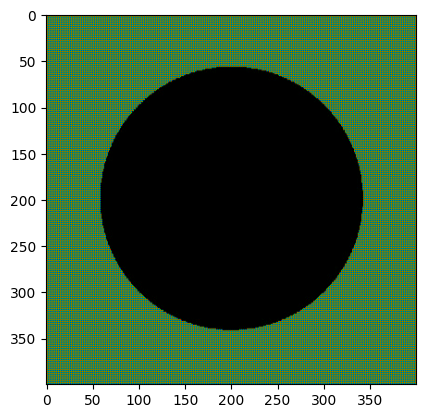

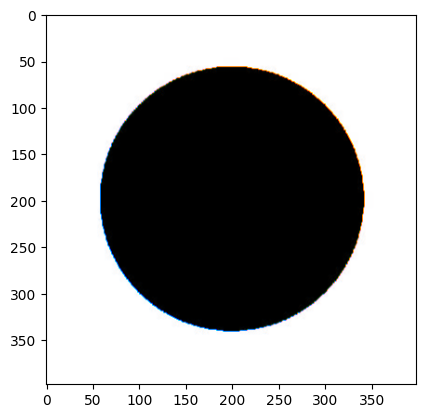

In [165]:
plt.imshow(circle_bayer)
plt.show()
plt.imshow(convolution_for_demosaicing(circle_bayer, demosaicing_with_given_kernel, 2, Bayer_red, Bayer_green, Bayer_blue, 1))
plt.show()

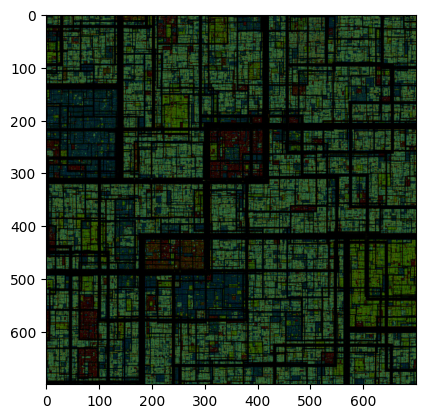

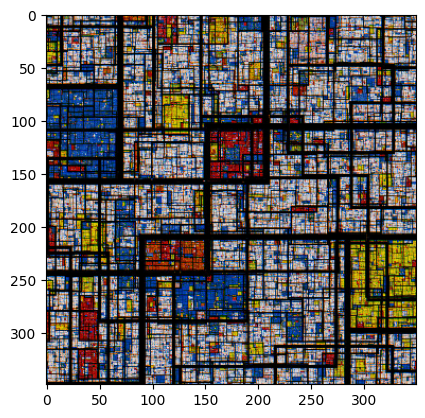

In [166]:
plt.imshow(mond_bayer)
plt.show()

plt.imshow(convolution_for_demosaicing(mond_bayer, demosaicing_with_given_kernel, 2, Bayer_red, Bayer_green, Bayer_blue, 2))
plt.show()

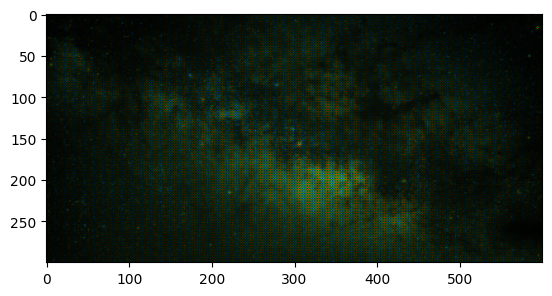

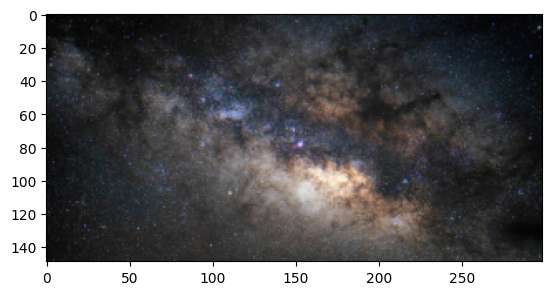

In [167]:
plt.imshow(milky_bayer)
plt.show()

plt.imshow(convolution_for_demosaicing(milky_bayer, demosaicing_with_given_kernel, 2, Bayer_red, Bayer_green, Bayer_blue))
plt.show()

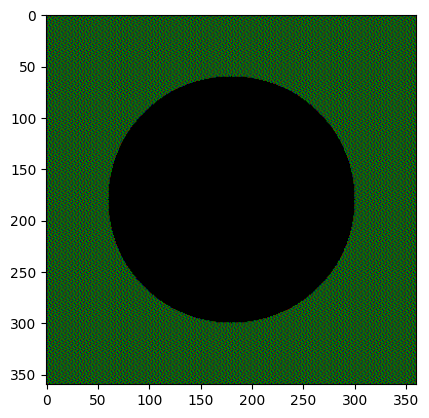

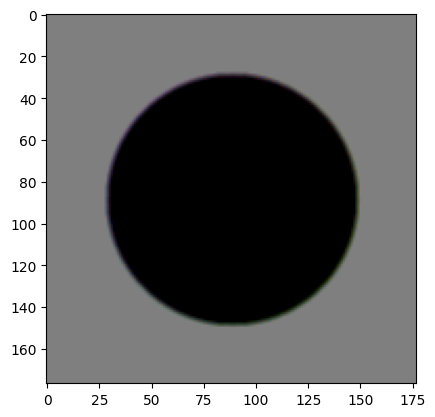

In [168]:
plt.imshow(raw_image)
plt.show()

plt.imshow(convolution_for_demosaicing(raw_image, demosaicing_with_given_kernel, 6, Fuji_red, Fuji_green, Fuji_blue, 2))
plt.show()

In [169]:
def kernel_filling_bayer_filter_values(data, matrix_size, matrix = 0):
  sum = [0] * 3
  matrix = np.array([[[1] * 3] * matrix_size] * matrix_size)
  for i in range(matrix_size):
    for j in range(matrix_size):
        sum[0] += data[i][j][0] * matrix[i][j][0] * 4
        sum[1] += data[i][j][1] * matrix[i][j][1] * 2
        sum[2] += data[i][j][2] * matrix[i][j][2] * 4
  sum = np.divide(sum, np.power(matrix_size, 2))
  return np.array(sum)

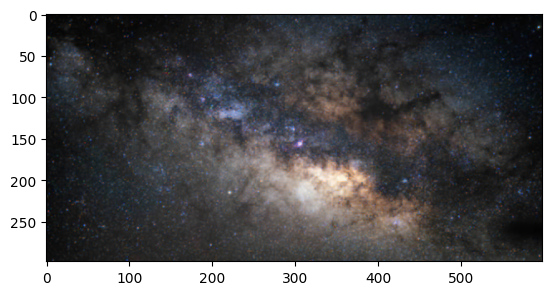

In [170]:
plt.imshow(convolution(milky_bayer, kernel_filling_bayer_filter_values, 2, 1))
plt.show()